In [1]:
import pandas as pd

df = pd.read_csv('netflix_titles.csv')

In [5]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 구두점 제거
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

# 불용어 정의
stop_words = set(stopwords.words('english'))

# 불용어 제거 및 토큰화 함수 정의
def tokenize_and_remove_stopwords(text):
    # 토큰화
    tokens = word_tokenize(text)
    # 불용어 제거
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# description 열에 대해 전처리 수행
df['cleaned_description'] = df['description'].apply(preprocess_text)
df['tokenized_description'] = df['cleaned_description'].apply(tokenize_and_remove_stopwords)

In [4]:
print(df['cleaned_description'])

0       before planning an awesome wedding for his gra...
1       jandino asporaat riffs on the challenges of ra...
2       with the help of three human allies the autobo...
3       when a prison ship crash unleashes hundreds of...
4       when nerdy high schooler dani finally attracts...
                              ...                        
6229    this parody of firstperson shooter games milit...
6230    marc maron stars as marc maron who interviews ...
6231    nursery rhymes and original music for children...
6232    set during the russian revolution this comic m...
6233    this hit sitcom follows the merry misadventure...
Name: cleaned_description, Length: 6234, dtype: object


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화 객체 생성
tfidf_vectorizer = TfidfVectorizer()

# 빈 문자열 제거
df = df[df['cleaned_description'] != '']

# TF-IDF 행렬 생성
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_description'])

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF 유사도 계산
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [20]:
from sklearn.metrics import jaccard_score

# 등급을 숫자로 매핑하는 딕셔너리 생성
rating_mapping = {'TV-Y': 1, 'TV-Y7': 2, 'TV-G': 3, 'TV-PG': 4, 'TV-14': 5, 'TV-MA': 6}

# 각 등급별로 유사도와 평가 지표 출력
for rating in sorted(df['rating'].map(rating_mapping).unique()):
    print(f"Ratings {rating}")
    rating_indices = df[df['rating'].map(rating_mapping) == rating].index
    
    # 해당 등급에 해당하는 영화가 없을 경우 건너뜀
    if len(rating_indices) == 0:
        print("No movies for this rating.")
        continue
    
    # 해당 등급의 TF-IDF 유사도 행렬 추출
    rating_cosine_sim = cosine_sim[rating_indices][:, rating_indices]
    
    # 코사인 유사도 평균
    avg_cosine_sim = rating_cosine_sim.mean()
    
    # 자카드 유사도 계산을 위한 기준 벡터 생성
    threshold = 0.5  # 예시 임계값 설정
    binary_tfidf_matrix = (tfidf_matrix[rating_indices] > threshold).astype(int)
    
    # 자카드 유사도 계산
    jaccard_sim = jaccard_score(binary_tfidf_matrix, binary_tfidf_matrix, average='samples')
    
    # TF 가중치 계산
    tf_weight = avg_cosine_sim * jaccard_sim
    
    print(f"cos sim : {avg_cosine_sim:.6f}, jaccard sim : {jaccard_sim:.6f}, tf_weight : {tf_weight:.6f}")


Ratings 4.0
cos sim : 0.021460, jaccard sim : 0.019971, tf_weight : 0.000429
Ratings 6.0
cos sim : 0.019416, jaccard sim : 0.013814, tf_weight : 0.000268
Ratings nan
No movies for this rating.
Ratings 1.0
cos sim : 0.037793, jaccard sim : 0.041958, tf_weight : 0.001586
Ratings 2.0
cos sim : 0.031567, jaccard sim : 0.017751, tf_weight : 0.000560
Ratings 3.0
cos sim : 0.026444, jaccard sim : 0.020134, tf_weight : 0.000532
Ratings 5.0
cos sim : 0.021120, jaccard sim : 0.010012, tf_weight : 0.000211


In [17]:
# 각 영화별로 유사도가 가장 높은 다른 영화를 찾아 출력
for idx, movie in enumerate(df['title']):
    # 해당 영화와 유사도가 높은 다른 영화의 인덱스를 찾음
    similar_movies_indices = cosine_sim[idx].argsort()[::-1][1:]
    
    # 출력
    print(f"{movie}와(과) 유사한 영화:")
    for sim_idx in similar_movies_indices[:5]:
        print(f"- {df.iloc[sim_idx]['title']}")
    print()

Norm of the North: King Sized Adventure와(과) 유사한 영화:
- Norm of the North: Keys to the Kingdom
- Paradise Beach
- Another Life
- Yo-Kai Watch: The Movie
- Maggie & Bianca: Fashion Friends

Jandino: Whatever it Takes와(과) 유사한 영화:
- Katt Williams: Great America
- Garfunkel and Oates: Trying to be Special
- Tom Papa Live in New York City
- Dany Boon: Des Hauts De France
- Backdraft 2

Transformers Prime와(과) 유사한 영화:
- Transformers: Robots in Disguise
- Beyond Skyline
- Naruto Shippûden the Movie: The Will of Fire
- Ultraman
- ​SAINT SEIYA: Knights of the Zodiac

Transformers: Robots in Disguise와(과) 유사한 영화:
- Transformers Prime
- Ultraman
- Chappaquiddick
- 최강전사 미니특공대 : 영웅의 탄생
- Edgar Rice Burroughs' Tarzan and Jane

#realityhigh와(과) 유사한 영화:
- Follow Me
- The Only Mother To You All
- Oh My Ghost
- Love O2O
- Deadcon

Apaches와(과) 유사한 영화:
- In Family I Trust
- Fatal Destiny
- The End of the F***ing World
- Shameless (U.S.)
- Boss

Automata와(과) 유사한 영화:
- The Adjusters
- The Rainmaker
- Mantra
- F

In [13]:
# 특정 영화의 인덱스
movie_index = 0

# 특정 영화와 다른 영화들의 유사도 확인
similar_movies_indices = cosine_sim[movie_index].argsort()[::-1][1:]

# 유사한 영화 출력
for idx in similar_movies_indices[:100]:
    print(df.iloc[idx]['title'])

Norm of the North: Keys to the Kingdom
Paradise Beach
Another Life
Yo-Kai Watch: The Movie
Maggie & Bianca: Fashion Friends
Pororo - The Little Penguin
Fate/Zero
Lovesong
We Bare Bears
Everybody Knows
F.R.E.D.I.
Chopsticks
Starsky & Hutch
Walking Out
The Lovers
Enter the Warriors Gate
Ingress: The Animation
Frozen Planet: The Epic Journey
Kong: King of the Apes
Immortals
Inspector Gadget
Where's the Money
Garuda Di Dadaku
The Daughter
The King
AJIN: Demi-Human
Sangam
Ottaal
Fangbone
DJ Cinderella
Goldie & Bear
Héroes
DC's Legends of Tomorrow
Sardaar ji
Brother in Love
The New Legends of Monkey
The Prince Who Turns into a Frog
Khoobsurat
Back to 1989
The Seven Deadly Sins
Danur: I Can See Ghosts
In Defense of a Married Man
Seven in Heaven
Aram, Aram
Khosla Ka Ghosla
Chhota Bheem Ka Romani Adventure
You're Everything To Me
TE3N
The Week Of
Heartland
Little Singham: Mahabali
Twins Mission
Jagga Jasoos
Kacche Dhaagey
The Confirmation
Green Eggs and Ham
Care Bears & Cousins
Manje Bistre
Ame

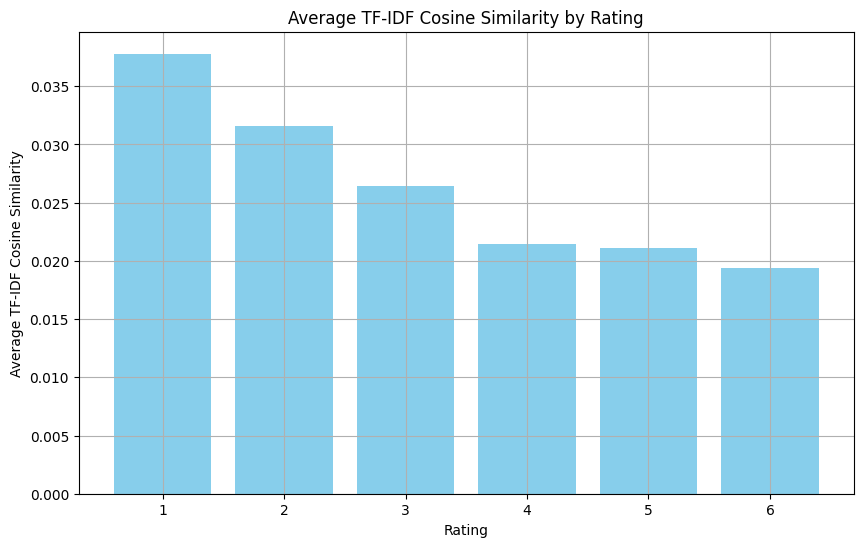

In [22]:
import matplotlib.pyplot as plt

# 등급별 평균 TF-IDF 유사도 저장할 리스트
avg_cos_sim_list = []
ratings_list = []

# 각 등급별로 유사도와 평가 지표 계산 및 리스트에 추가
for rating in sorted(df['rating'].map(rating_mapping).unique()):
    rating_indices = df[df['rating'].map(rating_mapping) == rating].index
    
    # 해당 등급에 해당하는 영화가 없을 경우 건너뜀
    if len(rating_indices) == 0:
        continue
    
    # 해당 등급의 TF-IDF 유사도 행렬 추출
    rating_cosine_sim = cosine_sim[rating_indices][:, rating_indices]
    
    # 코사인 유사도 평균
    avg_cosine_sim = rating_cosine_sim.mean()
    
    avg_cos_sim_list.append(avg_cosine_sim)
    ratings_list.append(rating)

# 막대 차트 생성
plt.figure(figsize=(10, 6))
plt.bar(ratings_list, avg_cos_sim_list, color='skyblue')

# 차트 제목 및 축 라벨 설정
plt.title('Average TF-IDF Cosine Similarity by Rating')
plt.xlabel('Rating')
plt.ylabel('Average TF-IDF Cosine Similarity')

# x 축 눈금 레이블 설정
plt.xticks(ratings_list)

# 그리드 표시
plt.grid(True)

# 차트 표시
plt.show()

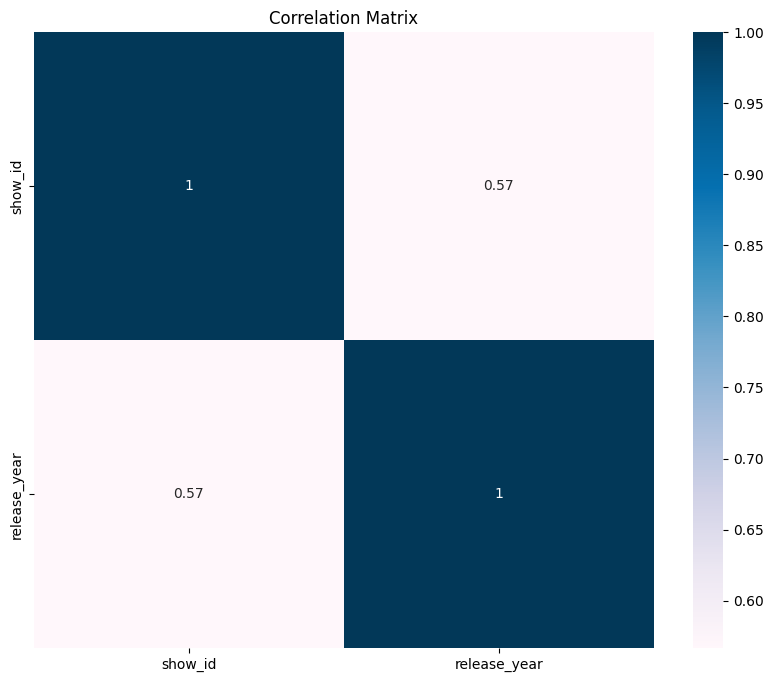

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관 행렬 생성
corr_matrix = df.corr()

# heatmap 생성
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='PuBu')
plt.title('Correlation Matrix')
plt.show()
